In [2]:
import os

import matplotlib.pyplot as plt
import torch
import pyro
import numpy as np
import pandas as pd
import seaborn as sns
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

from pyro import poutine
from pyro.nn import PyroModule, PyroParam, PyroSample
plt.style.use('ggplot')

In [25]:
class simple_model(PyroModule):
    def __init__(self, wavelength_range: tuple =(150, 900)):
        super().__init__()
        self.target = PyroSample(dist.Uniform(0,1000))
        self.variance = PyroSample(dist.Normal(200,50))
        self.max = PyroSample(dist.Uniform(100,500))
    def forward(self, x, y=None):
        sigma = pyro.sample('sigma', dist.Normal(10,5))
        mean = torch.exp(-1/2 * ((x - self.target)/self.variance)**2) * self.max
        with pyro.plate('data', x.shape[0]):
            obs = pyro.sample('obs', dist.Normal(mean, sigma), obs=y)
        return mean

def create_simple_data(nsamples: int = 5000):
    wavelengths = np.random.uniform(120, 900, nsamples)
    mean_lambda = np.random.uniform(0, 1000)
    sigma = np.random.randn() * 50 + 200
    max_fr = np.random.uniform(100, 500)
    true_rate = max_fr * np.exp(-1/2 * ((wavelengths - mean_lambda)/sigma)**2)
    observation = true_rate + np.random.randn(true_rate.shape[0])*20
    ground_truth = dict({'mean': mean_lambda, 'variance': sigma})
    return observation, wavelengths, ground_truth

torch.Size([5000, 3]) torch.Size([3]) torch.Size([3])
torch.Size([5000, 3]) torch.Size([3]) torch.Size([3])
[iteration 0001] loss: 158.9334
torch.Size([5000, 3]) torch.Size([3]) torch.Size([3])
torch.Size([5000, 3]) torch.Size([3]) torch.Size([3])
torch.Size([5000, 3]) torch.Size([3]) torch.Size([3])
torch.Size([5000, 3]) torch.Size([3]) torch.Size([3])
torch.Size([5000, 3]) torch.Size([3]) torch.Size([3])
torch.Size([5000, 3]) torch.Size([3]) torch.Size([3])
torch.Size([5000, 3]) torch.Size([3]) torch.Size([3])
torch.Size([5000, 3]) torch.Size([3]) torch.Size([3])
torch.Size([5000, 3]) torch.Size([3]) torch.Size([3])
torch.Size([5000, 3]) torch.Size([3]) torch.Size([3])
torch.Size([5000, 3]) torch.Size([3]) torch.Size([3])
torch.Size([5000, 3]) torch.Size([3]) torch.Size([3])
torch.Size([5000, 3]) torch.Size([3]) torch.Size([3])
torch.Size([5000, 3]) torch.Size([3]) torch.Size([3])
torch.Size([5000, 3]) torch.Size([3]) torch.Size([3])
torch.Size([5000, 3]) torch.Size([3]) torch.Size([

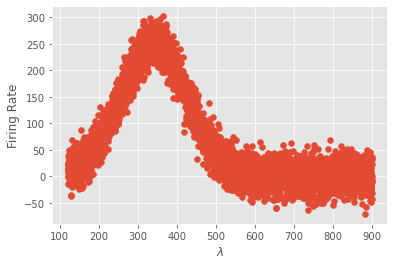

In [26]:
data , input, ground_truth = create_simple_data()

plt.figure()
plt.scatter(input, data)
plt.ylabel('Firing Rate')
plt.xlabel(r'$\lambda$')
data = torch.from_numpy(data)
input = torch.from_numpy(input)

(5000,)

In [18]:
def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats

In [27]:
from pyro.infer.autoguide import AutoDiagonalNormal
model = simple_model()
guide = AutoDiagonalNormal(model)

In [28]:
from pyro.infer import SVI, Trace_ELBO
optimizer = pyro.optim.Adam({'lr': .01})
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

(torch.Size([5000]), torch.Size([5000, 1]))

In [29]:
n_iterations = 10000
plot_epochs = 50
pyro.clear_param_store()
for j in range(n_iterations):
    loss = svi.step(input, data)
    if j % plot_epochs == 0:
         print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

[iteration 0001] loss: 147.9701
[iteration 0051] loss: 91.0824
[iteration 0101] loss: 53.7431
[iteration 0151] loss: 36.3059
[iteration 0201] loss: 29.7516
[iteration 0251] loss: 25.1874
[iteration 0301] loss: 18.4511
[iteration 0351] loss: 18.2181
[iteration 0401] loss: 15.9963
[iteration 0451] loss: 14.4286
[iteration 0501] loss: 13.5738
[iteration 0551] loss: 13.1799
[iteration 0601] loss: 13.0508
[iteration 0651] loss: 12.9889
[iteration 0701] loss: 12.5065
[iteration 0751] loss: 12.2884
[iteration 0801] loss: 12.1518
[iteration 0851] loss: 11.7914
[iteration 0901] loss: 11.7484
[iteration 0951] loss: 11.5243


In [30]:
from pyro.infer import Predictive
predictive = Predictive(model, guide=guide, num_samples=100,
                        return_sites=('obs', 'target', 'variance','_RETURN'))
samples = predictive(input)
pred_summary = summary(samples)
target_data = pred_summary['target']
variance_data = pred_summary['variance']
obs_data = pred_summary['obs']

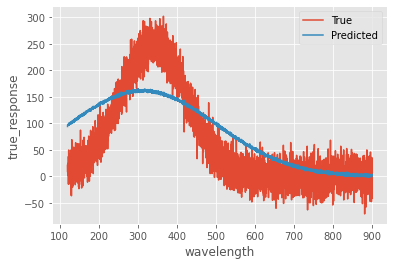

In [31]:
mu = pred_summary['_RETURN']
y = pred_summary['obs']

predictions = pd.DataFrame({
    'wavelength': input,
    'true_response': data,
    'predicted_response': y['mean']
})

plt.figure()
sns.lineplot(x='wavelength', y='true_response', data=predictions, label='True')
sns.lineplot(x='wavelength', y='predicted_response', data=predictions, label='Predicted')
plt.legend()


/home/elom/anaconda3/envs/ppl/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/elom/anaconda3/envs/ppl/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


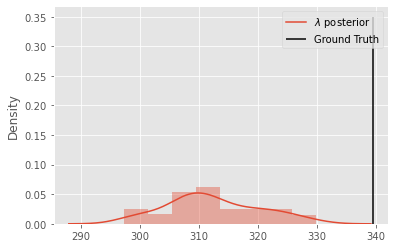

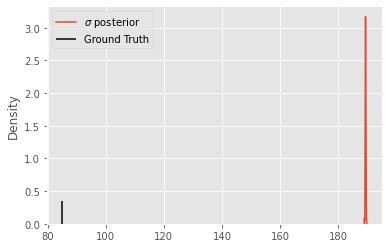

In [44]:
real_mean = ground_truth['mean']
real_sigma = ground_truth['variance']
plt.figure()
sns.distplot(samples['target'], kde_kws={'label': r'$\lambda$ posterior'})
plt.vlines(real_mean, 0, .35,'k',label='Ground Truth')
plt.legend()
plt.figure()
sns.distplot(samples['variance'], kde_kws={'label': r'$\sigma$ posterior'})
plt.vlines(real_sigma, 0, .35,'k',label='Ground Truth')
plt.legend()

tensor([[312.5545],
        [308.5127],
        [312.7008],
        [322.4889],
        [310.3600],
        [318.5573],
        [297.9674],
        [316.9604],
        [312.6091],
        [315.3194],
        [306.2240],
        [315.2236],
        [312.6785],
        [322.8109],
        [300.1422],
        [307.9350],
        [316.4157],
        [307.2204],
        [312.2927],
        [324.8685],
        [307.6028],
        [310.9694],
        [298.1983],
        [311.2401],
        [320.0887],
        [329.0932],
        [303.0965],
        [307.7282],
        [320.2469],
        [308.4801],
        [319.3203],
        [313.4293],
        [305.1187],
        [311.7203],
        [317.9023],
        [321.9827],
        [314.3985],
        [310.8873],
        [320.5684],
        [298.8827],
        [310.7851],
        [320.4866],
        [323.7961],
        [329.8899],
        [309.6892],
        [304.6061],
        [313.3167],
        [322.8433],
        [297.3087],
        [308.0113],
